In [30]:
#ライブラリをインポートする
%matplotlib inline 
import numpy as np
import pandas as pd 
import seaborn as sns
import datetime
from matplotlib import pyplot as plt 
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss,accuracy_score,confusion_matrix,precision_recall_fscore_support
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from IPython.display import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from dateutil.relativedelta import relativedelta
from sklearn.decomposition import PCA

In [2]:
#データを読み込む
data=pd.read_csv("./4104_16930_compressed_ks-projects-201801.csv/ks-projects-201801.csv")


In [3]:
#データの確認
print(data.info())
print(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB
None
           ID                                               name  \
0  1000002330                    The Songs of Adelaide & Abullah   
1  1000003930      Greeting From Eart

In [4]:
#⓵モデルにふさわしい変数を選択する
#変数：ID、goal,pledged,backers,usd_pledged,usd_pleged_realはドロップする
data=data.drop(["ID","goal","pledged","backers","usd pledged","usd_pledged_real"],axis=1)

In [5]:
#⓶目的変数をfailedとsucceddfulだけにしてfailed=0,successfu=1に変換する
data=data.query("state=='failed' | state=='successful'")

data.loc[data["state"]=='failed',["state"]]=0
data.loc[data["state"]=='successful',["state"]]=1

In [6]:
#⓷説明変数を考える（その1）
#nameの長さで変数を作る
data["name_length"]=data["name"].str.len()


29    148478
59     27969
44     15241
30     11724
34      8619
       ...  
81        46
76        45
73        43
78        35
91        22
Name: period, Length: 92, dtype: int64


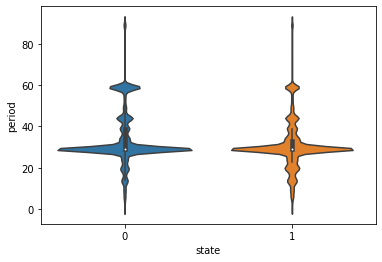

In [7]:
#⓷説明変数を考える（その2）
#期間の長さで変数を作る
data["deadline"]=pd.to_datetime(data["deadline"])
data["launched"]=pd.to_datetime(data["launched"])
date_delta=data["deadline"]-data["launched"]
#main_data["period"]=main_data["period"].days
data["period"]=date_delta.dt.days

data["period"].describe()
print(data["period"].value_counts())
sns.violinplot("state","period",data=data)


count    3.316750e+05
mean     4.151000e+04
std      1.108930e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.000000e+03
75%      1.500000e+04
max      1.663614e+08
Name: usd_goal_real, dtype: float64


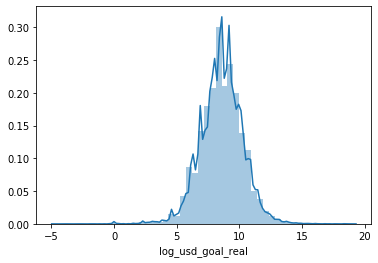

In [8]:
#⓷説明変数を考える（その3）
#usd_goal_realのヒストグラムを作成する
print(data["usd_goal_real"].describe())
#sns.distplot(data["usd_goal_real"])
#usd_goal_realで対数をとる
data["log_usd_goal_real"]=np.log(data["usd_goal_real"])
sns.distplot(data["log_usd_goal_real"])

Product Design     18680
Documentary        14523
Music              12633
Tabletop Games     11744
Shorts             11394
                   ...  
Residencies           68
Letterpress           46
Chiptune              33
Literary Spaces       19
Taxidermy             10
Name: category, Length: 159, dtype: int64
Film & Video    56527
Music           45949
Publishing      35445
Games           28521
Technology      27050
Art             25641
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64
   Art  Comics  Crafts  Dance  Design  Fashion  Film & Video  Food  Games  \
0    0       0       0      0       0        0             0     0      0   
1    0       0       0      0       0        0             1     0      0   
2    0       0       0      0       0        0             1     0      0   
3    0     

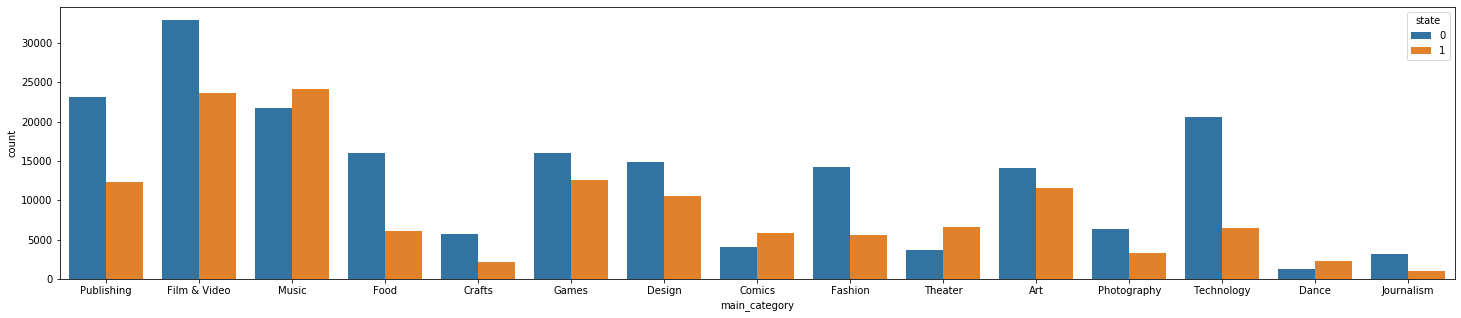

In [9]:
#⓷説明変数を考える(その４)
#categoryとmain_categoryの値を確認(159種類,15種類)
print(data["category"].value_counts())
print(data["main_category"].value_counts())

data1=pd.get_dummies(data["main_category"])
plt.figure(figsize = (25,5))
sns.countplot(data["main_category"],hue=data["state"])
print(data1.head())

USD    261511
GBP     29476
EUR     14378
CAD     12375
AUD      6621
SEK      1510
MXN      1411
NZD      1274
DKK       929
CHF       652
NOK       584
HKD       477
SGD       454
JPY        23
Name: currency, dtype: int64
US      261360
GB       29454
CA       12370
AU        6616
DE        3436
FR        2520
NL        2411
IT        2369
ES        1873
SE        1509
MX        1411
NZ        1274
DK         926
IE         683
CH         652
NO         582
BE         523
AT         485
HK         477
SG         454
N,0"       210
LU          57
JP          23
Name: country, dtype: int64
   currency_AUD  currency_CAD  currency_CHF  currency_DKK  currency_EUR  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
5             0            

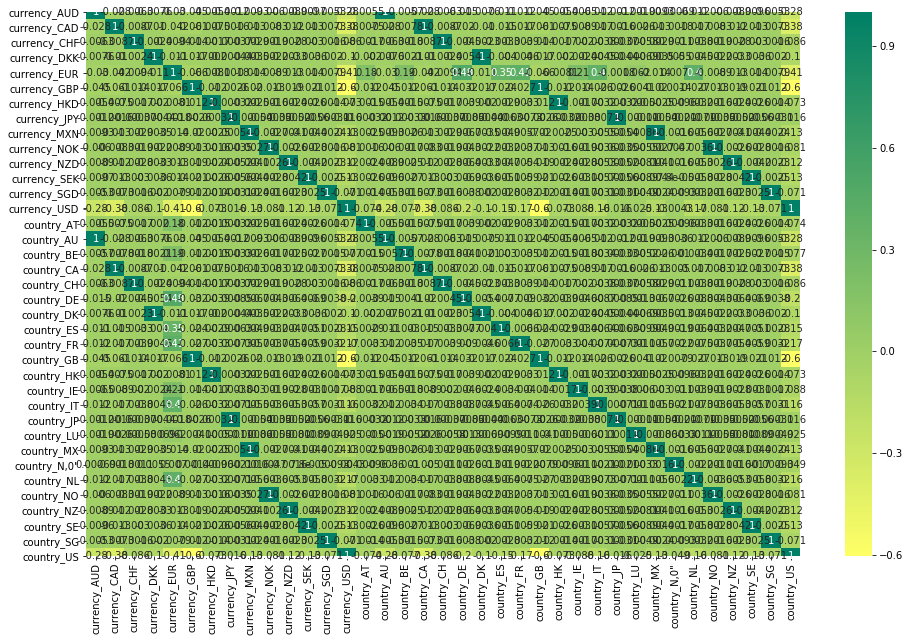

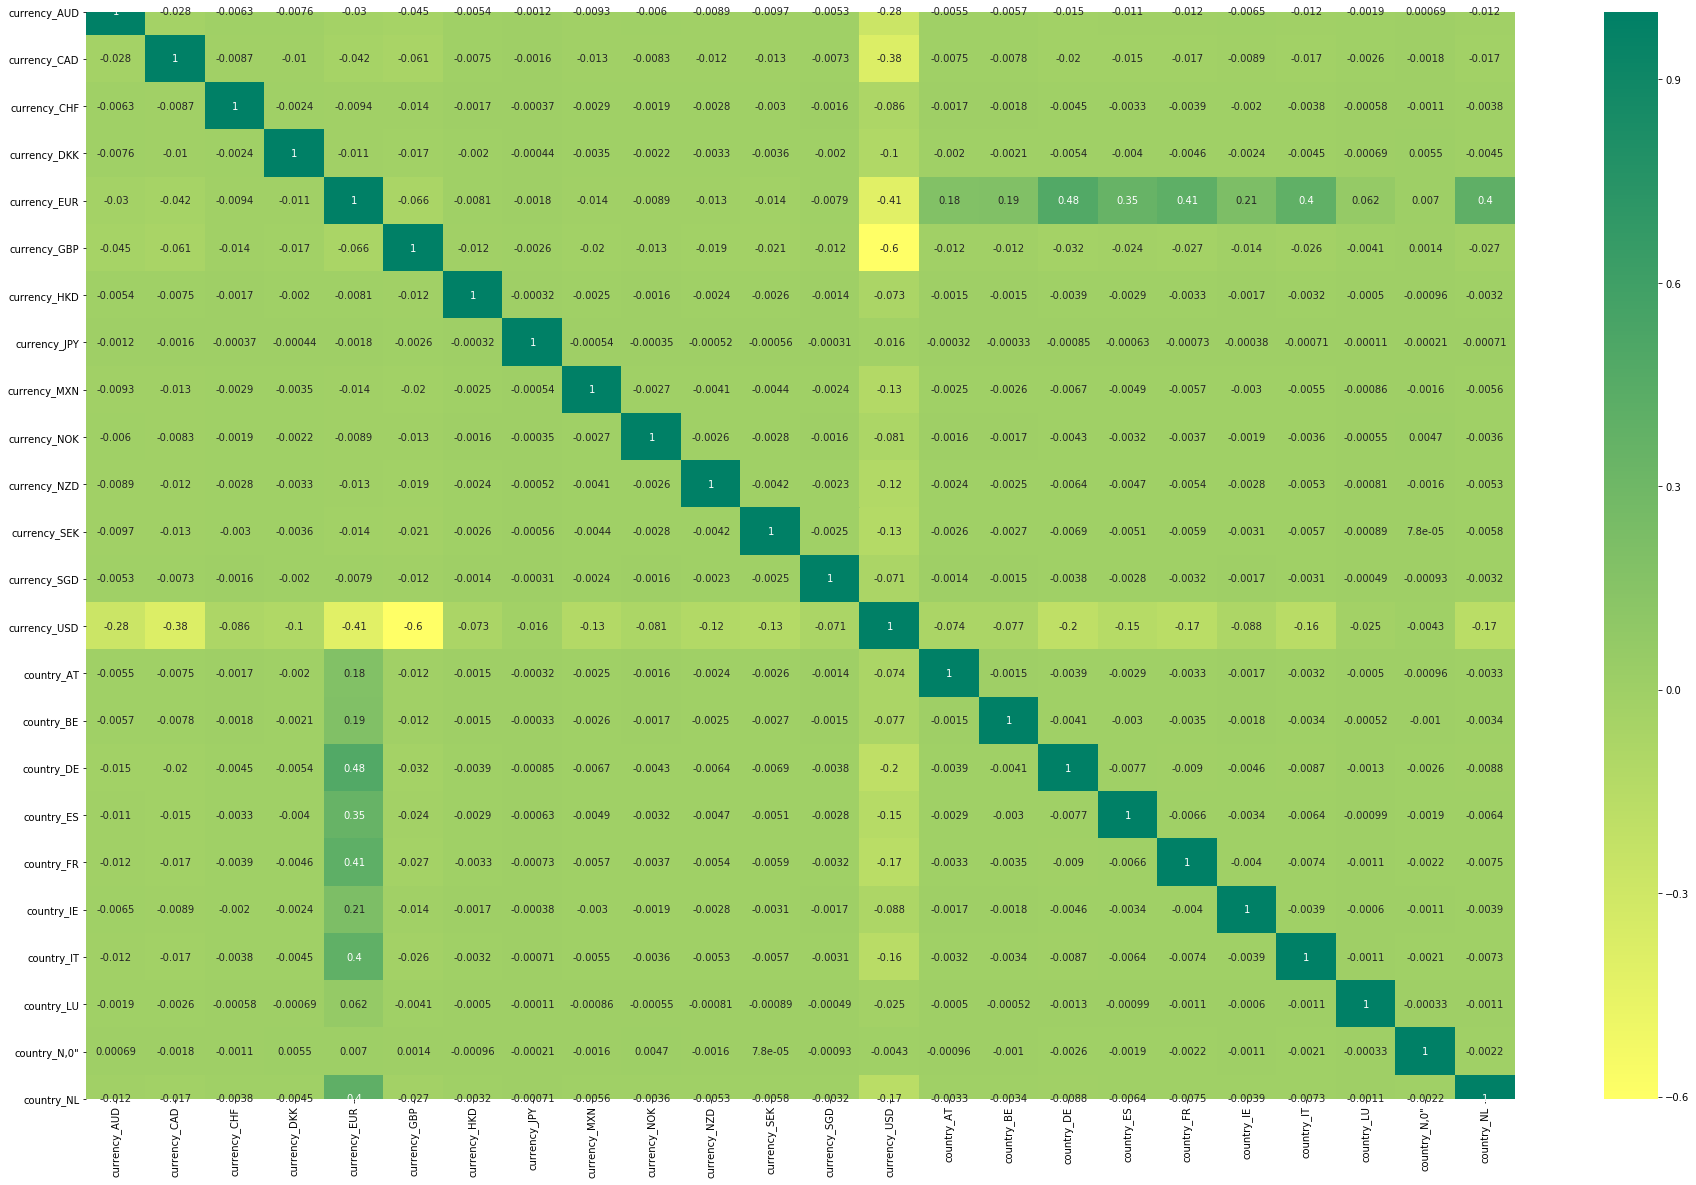

In [10]:
#⓷説明変数を考える(その5)
#currncyとcountryの関係を確認
print(data["currency"].value_counts())
print(data["country"].value_counts())

#currencyとcountryに相関があることを確認
data2=pd.get_dummies(data[["currency","country"]])
#data2=data2[["country_US","country_GB","currency_USD","currency_GBP"]]
print(data2.head())
plt.figure(figsize = (16,10))
sns.heatmap(data2.corr(),cmap="summer_r",annot=True)

#USDとGBPとAUDとCADのカントリーと通貨を無相関化する→ダミー変数同士の無相関化は意味がない
country=["country_US","country_GB","country_AU","country_CA","country_CH","country_DK","country_HK","country_JP","country_MX","country_NO","country_NZ","country_SE","country_SG"]
currency=["currency_USD","currency_GBP","currency_AUD","currency_CAD","currency_CHF","currency_DKK","currency_HKD","currency_JPY","currency_MXN","currency_NOK","currency_NZD","currency_SEK","currency_SGD"]
#data3=data2[["country_US","currency_USD","country_GB","currency_GBP",\"country_AU","currency_AUD","country_CA","currency_CAD"]]
"""
#  無相関化を行うための一連の処理
for co,cu in zip(country, currency):
    data3=data2[[co,cu]]
    cov = np.cov(data3, rowvar=0) # 分散・共分散を求める
    _, S = np.linalg.eig(cov)           # 分散共分散行列の固有ベクトルを用いて
    data3_decorr = np.dot(S.T, data3.T).T #データを無相関化

    #  白色化を行うための一連の処理
    stdsc = StandardScaler()
    stdsc.fit(data3_decorr)
    data3_whitening  = stdsc.transform(data3_decorr) # 無相関化したデータに対して、さらに標準化
    print(co,cu,'相関係数: {:.3f}'.format(np.corrcoef(data3_whitening[:, 0], data3_whitening[:, 1])[0,1]))
    print(data3_decorr)
    data2[co] = data3_decorr[:,0]
    data2[cu] = data3_decorr[:,1]
"""
#相関が高いcountryをドロップする
data2=data2.drop(country,axis=1)
plt.figure(figsize = (32,20))
sns.heatmap(data2.corr(),cmap="summer_r",annot=True)

#一旦はcurrencyを採用し、弱小通貨は"other"にまとめるてダミー変数化する
#data.loc[(data["currency"]!='USD') & (data["currency"]!='GBP') & (data["currency"]!='EUR') & (data["currency"]!='CAD') & (data["currency"]!='AUD'),["currency"]]="others"
#print(data["currency"].value_counts())

In [11]:
#⓷説明変数を考える(その6)
#前月の成功率を変数化する
#launchedをyyyymm形式にして変数化する
#data["deadline"]=pd.to_datetime(data["deadline"])
#data["launched"]=pd.to_datetime(data["launched"])
#print(data["launched"].dt.year)
print(data["deadline"])
data["trend"]=data["deadline"].dt.strftime("%Y%m")
data_grouped=data.groupby("trend")
print(data_grouped["state"].count())
print(data_grouped["state"].sum())
data3=data_grouped["state"].sum()/data_grouped["state"].count()
print(data3)
data3_shift=data3.shift(+1)

#data3=pd.get_dummies(data["trend"])


#print(data["trend"])
#print(data["trend"].describe())

0        2015-10-09
1        2017-11-01
2        2013-02-26
3        2012-04-16
5        2016-04-01
            ...    
378654   2017-04-19
378657   2011-07-19
378658   2010-08-16
378659   2016-02-13
378660   2011-08-16
Name: deadline, Length: 331675, dtype: datetime64[ns]
trend
200905      11
200906      28
200907      59
200908      62
200909      79
          ... 
201709    3587
201710    3791
201711    3992
201712    3991
201801     220
Name: state, Length: 105, dtype: int64
trend
200905       3
200906      16
200907      38
200908      33
200909      41
          ... 
201709    1483
201710    1652
201711    1789
201712    1714
201801      86
Name: state, Length: 105, dtype: int64
trend
200905    0.272727
200906    0.571429
200907    0.644068
200908    0.532258
200909    0.518987
            ...   
201709    0.413437
201710    0.435769
201711    0.448146
201712    0.429466
201801    0.390909
Name: state, Length: 105, dtype: float64


In [12]:
#%%
#dataとdata1とdata2をconcatする
dataA=pd.concat([data,data1],axis=1)
dataA=pd.concat([dataA,data2],axis=1)
dataA=pd.merge(dataA,data3_shift,on="trend")
print(dataA.head(5))
dataA.info()
dataA=dataA.rename(columns={"state_x":"state","state_y":"success_rate_1monthago"})
dataA.info()


                                                name        category  \
0                    The Songs of Adelaide & Abullah          Poetry   
1  Legacy of Svarog | a Unique 3D Action RPG and ...     Video Games   
2                          David LaRocca: Star Spawn    Illustration   
3  Mooli London | Designer Camera & Tech Bag - Th...  Product Design   
4  Funky Grits - fast casual diner pairing music ...     Restaurants   

  main_category currency   deadline            launched  state_x country  \
0    Publishing      GBP 2015-10-09 2015-08-11 12:12:28        0      GB   
1         Games      USD 2015-10-30 2015-08-31 06:33:31        0      US   
2           Art      USD 2015-10-22 2015-09-21 14:44:46        1      US   
3        Design      GBP 2015-10-10 2015-09-04 16:33:23        1      GB   
4          Food      USD 2015-10-01 2015-09-03 17:32:07        0      US   

   usd_goal_real  name_length  ...  country_BE  country_DE country_ES  \
0        1533.95         31.0  ...   

In [14]:
#分析に使うデータ変数だけにする
#分析に使うデータ変数だけにする
#dataA=dataA.drop(["name","category","main_category",\"currency","deadline","launched","country","usd_goal_real","trend","others"],axis=1)
dataA=dataA.drop(["name","category","main_category",\
    "currency","deadline","launched","country","usd_goal_real","trend"],axis=1)
dataA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 331674
Data columns (total 44 columns):
state                     331675 non-null int64
name_length               331672 non-null float64
period                    331675 non-null int64
log_usd_goal_real         331675 non-null float64
Art                       331675 non-null uint8
Comics                    331675 non-null uint8
Crafts                    331675 non-null uint8
Dance                     331675 non-null uint8
Design                    331675 non-null uint8
Fashion                   331675 non-null uint8
Film & Video              331675 non-null uint8
Food                      331675 non-null uint8
Games                     331675 non-null uint8
Journalism                331675 non-null uint8
Music                     331675 non-null uint8
Photography               331675 non-null uint8
Publishing                331675 non-null uint8
Technology                331675 non-null uint8
Theater              

               state    name_length         period  log_usd_goal_real  \
count  331661.000000  331661.000000  331661.000000      331661.000000   
mean        0.403885      34.220210      32.955243           8.580903   
std         0.490676      15.961259      12.713234           1.673250   
min         0.000000       1.000000       0.000000          -4.605170   
25%         0.000000      21.000000      29.000000           7.600902   
50%         0.000000      33.000000      29.000000           8.517193   
75%         1.000000      48.000000      35.000000           9.615805   
max         1.000000      85.000000      91.000000          18.929673   

                 Art         Comics         Crafts          Dance  \
count  331661.000000  331661.000000  331661.000000  331661.000000   
mean        0.077299       0.029783       0.023572       0.010773   
std         0.267065       0.169990       0.151712       0.103233   
min         0.000000       0.000000       0.000000       0.000000 

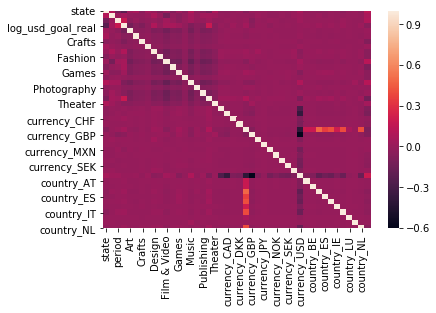

In [15]:
#⓸異常値、Null値、欠損値について考える
#欠損値はname_lengthの3件のみ、欠損値を含むレコードはdeleteする
dataA=dataA.dropna(how='any')

"""
ここまでで使いたい変数はそろえた！変数を変えるときは↑までを変える
"""
print(dataA.describe())
print(dataA.isnull().sum())
sns.heatmap(dataA.corr())
plt.show()

               state    name_length         period  log_usd_goal_real  \
count  331661.000000  331661.000000  331661.000000      331661.000000   
mean        0.403885      34.220210      32.955243           8.580903   
std         0.490676      15.961259      12.713234           1.673250   
min         0.000000       1.000000       0.000000          -4.605170   
25%         0.000000      21.000000      29.000000           7.600902   
50%         0.000000      33.000000      29.000000           8.517193   
75%         1.000000      48.000000      35.000000           9.615805   
max         1.000000      85.000000      91.000000          18.929673   

                 Art         Comics         Crafts          Dance  \
count  331661.000000  331661.000000  331661.000000  331661.000000   
mean        0.077299       0.029783       0.023572       0.010773   
std         0.267065       0.169990       0.151712       0.103233   
min         0.000000       0.000000       0.000000       0.000000 

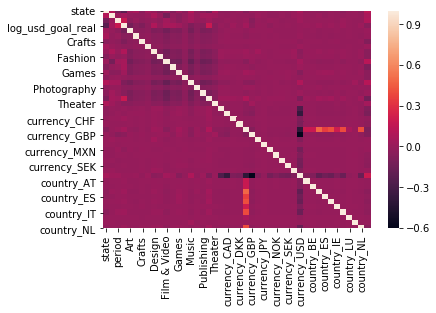

In [16]:
#⓸異常値、Null値、欠損値について考える
#欠損値はname_lengthの3件のみ、欠損値を含むレコードはdeleteする
dataA=dataA.dropna(how='any')

"""
ここまでで使いたい変数はそろえた！変数を変えるときは↑までを変える
"""
print(dataA.describe())
print(dataA.isnull().sum())
sns.heatmap(dataA.corr())
plt.show()

In [31]:
"""
↓ここからDAY１のやり直し
DAY1では変数がプロジェクト成功後に取得可能な変数も含んでしまっていたのでここで改めて
やってみる
"""
#ロジスティック回帰を行う
y=dataA["state"].values
X=dataA.drop("state",axis=1).values

#max_iter=学習の反復の最大回数
clf=SGDClassifier(loss="log",penalty='none',max_iter=10000, \
    fit_intercept=True,random_state=1234,tol=1e-3)
clf.fit(X,y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log',
              max_iter=10000, n_iter_no_change=5, n_jobs=None, penalty='none',
              power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [32]:
#モデルの評価
y_pred=clf.predict(X)
print(f"対数尤度:{log_loss(y,y_pred):.3f}")
print(f"正答率:{accuracy_score(y,y_pred)*100:.3f}")
DAY1_accuracy=accuracy_score(y,y_pred)*100


対数尤度:11.846
正答率:65.703


In [19]:
#モデルを評価する（RECALL,ACCURACY,PRECISION)
# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「2000万以上」に関するPrecision, Recall, F1-scoreを表示
print(f'適合率（Precision） = {100 * precision[0]:.3f}%')
print(f'再現率（Recall） = {100 * recall[0]:.3f}%')
print(f'F1値（F1-score） = {100 * f1_score[0]:.3f}%')

DAY1_Precision=100 * precision[0]
DAY1_Recall=100 * recall[0]
DAY1_F1score=100 * f1_score[0]

適合率（Precision） = 67.387%
再現率（Recall） = 82.292%
F1値（F1-score） = 74.097%


In [20]:
#クロス表を作る
conf_mat=pd.DataFrame(confusion_matrix(y,y_pred),\
    index=['実際：×','実際：〇'],\
    columns=['予測:×','予測:〇'])
display(conf_mat)

"""
↑ここまでDAY１のやり直し
"""

,予測:×,予測:〇
実際：×,162697,35011
実際：〇,78740,55213


'\n↑ここまでDAY１のやり直し\n'

In [21]:
#⓹最後のフォールドアウト法のためのテストデータと訓練データの分割を行う
dataA_y=dataA["state"].values
dataA_x=dataA.drop(["state"],axis=1).values
test_size=0.2
dataA_x_train,dataA_x_test,dataA_y_train,dataA_y_test= \
    train_test_split(dataA_x,dataA_y,test_size=test_size,random_state=1234)

"""
dataA_x_train,,dataA_y_train→さらにクロスバリデーションへ
dataA_x_test,dataA_y_test→ホールドアウト法
"""

'\ndataA_x_train,,dataA_y_train→さらにクロスバリデーションへ\ndataA_x_test,dataA_y_test→ホールドアウト法\n'

In [22]:
#⓺グリッドサーチでL2正則化のペナルティ項の係数を探す。ロジスティック回帰。
#dataA_x_train, dataA_y_trainを使う

model=SGDClassifier(random_state=1234)
parameters={'penalty':['l2', 'l1', 'elasticnet'],'alpha':[1,0.1,0.01,1e-3,1e-4,1e-5]}
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(dataA_x_train, dataA_y_train)
print(clf.best_params_, clf.best_score_)

{'alpha': 0.001, 'penalty': 'elasticnet'} 0.6476059820297896


In [23]:
#⓻交差検証法を
# ロジスティック回帰モデルで
# dataA_x_train,,dataA_y_trainでおこなう

n_split = 5 # グループ数を設定（今回は5分割）
cross_valid_accuracy_test = 0
cross_valid_accuracy_learning = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_index,test_index in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(dataA_x_train, dataA_y_train):
    #print(X[train_index],y[train_index])
    X_train,y_train=dataA_x_train[train_index],dataA_y_train[train_index]
    X_test,y_test=dataA_x_train[test_index],dataA_y_train[test_index]

    #データの標準化を行う※※※    
    stdsc = StandardScaler()
    X_train_stand = stdsc.fit_transform(X_train)
    #plt.hist(X_train_stand[:, 0]) #標準化後の1つ目の特徴に関するヒストグラム（学習用データ）
    X_test_stand = stdsc.transform(X_test)
    #plt.hist(X_test_stand[:, 0]) #標準化後の1つ目の特徴に関するヒストグラム（テストデータ）

    # 学習用データを使ってロジスティック回帰モデルを学習
    #reg=LinearRegression(fit_intercept=True)
    clf=SGDClassifier(\
        loss="log",\
        penalty='elasticnet',\
        alpha=0.001, \
        max_iter=10000, \
        fit_intercept=True,random_state=1234,tol=1e-3)
    clf.fit(X_train_stand,y_train)

    # 学習データに対する予測を実行
    y_train_predict=clf.predict(X_train_stand)

    # 学習データに対するAccuracyを計算
    
    #print(f"対数尤度:{log_loss(y_train,y_train_predict):.3f}")
    accuracy_learning=accuracy_score(y_train,y_train_predict)*100


    # テストデータに対する予測を実行
    y_predict_test=clf.predict(X_test_stand)

    # テストデータに対するMAEを計算
    
    #mae=mean_absolute_error(y_test,y_predict_test)
    accuracy_test=accuracy_score(y_test,y_predict_test)*100
    print(f"{split_num}回目:Accuracy_learning{accuracy_learning:.3f}")
    print(f"{split_num}回目:Accuracy_test{accuracy_test:.3f}")
    #後で平均を取るためにAccuracyを加算
    cross_valid_accuracy_learning+=accuracy_learning
    cross_valid_accuracy_test+=accuracy_test
    split_num += 1
    print(split_num)

1回目:Accuracy_learning65.807
1回目:Accuracy_test65.498
2
2回目:Accuracy_learning65.755
2回目:Accuracy_test65.575
3
3回目:Accuracy_learning65.682
3回目:Accuracy_test66.008
4
4回目:Accuracy_learning65.863
4回目:Accuracy_test65.900
5
5回目:Accuracy_learning65.824
5回目:Accuracy_test65.829
6


In [24]:
#accuracyの平均をとる
final_accuracy_learning=cross_valid_accuracy_learning/n_split
final_accuracy_test=cross_valid_accuracy_test/n_split
print(f"cross varidation accuracy:{final_accuracy_learning:.3f}")
print(f"cross varidation accuracy:{final_accuracy_test:.3f}")


cross varidation accuracy:65.786
cross varidation accuracy:65.762


In [34]:
#⓼グリッドサーチ法で最適とわかったモデルをクロスバリデーションで評価した後、
# ホールドアウト法を用いてdataA_x_trainで学習しdataA_y_trainで汎化誤差を測って
#予測モデルを確定させる

#標準化を実装 
stdsc = StandardScaler()
dataA_x_train_stand = stdsc.fit_transform(dataA_x_train)
print(dataA_x_train_stand)
#plt.hist(X_train_stand[:, 0]) #標準化後の1つ目の特徴に関するヒストグラム（学習用データ）
dataA_x_test_stand = stdsc.transform(dataA_x_test)
#plt.hist(X_test_stand[:, 0]) #標準化後の1つ目の特徴に関するヒストグラム（テストデータ）


# 学習用データを使って線形回帰モデルを学習
clf=SGDClassifier(loss="log",penalty='l2',alpha=0.001, \
    max_iter=10000,fit_intercept=True, \
        random_state=1234,tol=1e-3)
clf.fit(dataA_x_train_stand,dataA_y_train)

# 学習用データに対する予測を実行
y_predict_train=clf.predict(dataA_x_train_stand)

# 学習データに対するAccuracyを計算（訓練誤差の評価）
accuracy=accuracy_score(dataA_y_train,y_predict_train)
print(f"Accuracy:{accuracy*100:.3f}")

# テストデータに対する予測を実行
y_predict_test=clf.predict(dataA_x_test_stand)

# テストデータに対するAccuracyを計算（汎化誤差の評価）
accuracy_test=accuracy_score(dataA_y_test,y_predict_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(dataA_y_test,y_predict_test)
print(f"Accuracy_test:{accuracy_test*100:.3f}")
print(f'適合率（Precision） = {100 * precision[0]:.3f}%')
print(f'再現率（Recall） = {100 * recall[0]:.3f}%')
print(f'F1値（F1-score） = {100 * f1_score[0]:.3f}%')

[[-0.38847799 -0.31103221 -0.75755796 ... -0.02576374 -0.08499451
   1.40366023]
 [ 0.3010135  -0.31103221 -0.75755796 ... -0.02576374 -0.08499451
   1.42478355]
 [ 1.49195333 -0.31103221  0.87371732 ... -0.02576374 -0.08499451
  -1.20054875]
 ...
 [ 1.3039102   0.63255283  1.03165464 ... -0.02576374 -0.08499451
  -0.97449032]
 [ 0.7397808  -0.07513595 -0.64866571 ... -0.02576374 -0.08499451
   1.07345502]
 [ 0.48905663 -0.07513595  1.75073202 ... -0.02576374 -0.08499451
  -1.34660615]]
Accuracy:65.717
Accuracy_test:65.559
適合率（Precision） = 67.285%
再現率（Recall） = 81.882%
F1値（F1-score） = 73.869%


In [33]:
print(f"DAY1_accuracy:{DAY1_accuracy}")
print(f"DAY1_Precision:{DAY1_Precision}")
print(f"DAY1_Recall:{DAY1_Recall}")
print(f"DAY1_F1score:{DAY1_F1score}")

"""
訓練誤差、汎化誤差ともに低く、未学習の状態と考えられる
DAY１と比較しても特段モデルの改善は図れなかった。

"""

DAY1_accuracy:65.70263009518756
DAY1_Precision:67.38693737910924
DAY1_Recall:82.29156129241103
DAY1_F1score:74.09716608409524


'\n訓練誤差、汎化誤差ともに低く、未学習の状態と考えられる\nDAY１と比較しても特段モデルの改善は図れなかった。\n\n'

In [37]:
"""
↓SVMを1000個のデータでやってみる(dataB)
"""
dataB=dataA.sample(n=1000,random_state=1234)
#⓹最後のフォールドアウト法のためのテストデータと訓練データの分割を行う
dataB_y=dataB["state"].values
dataB_x=dataB.drop(["state"],axis=1).values
test_size=0.2
dataB_x_train,dataB_x_test,dataB_y_train,dataB_y_test= \
    train_test_split(dataB_x,dataB_y,test_size=test_size,random_state=1234)

"""
dataA_x_train,,dataA_y_train→さらにクロスバリデーションへ
dataA_x_test,dataA_y_test→ホールドアウト法
"""

'\ndataA_x_train,,dataA_y_train→さらにクロスバリデーションへ\ndataA_x_test,dataA_y_test→ホールドアウト法\n'

In [38]:
#⑨グリッドサーチでSVMのペナルティ項の係数を探す。
#データ数は1000ぐらいに抑えてみる
parameters = {'kernel':['linear', 'rbf'], 'C':[1,2,3,4,5]} # ここを編集する
model = SVC(gamma="scale") # gamma=scaleにすると、gammaが自動で計算される
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(dataB_x_train, dataB_y_train)
print(clf.best_params_, clf.best_score_)

{'C': 5, 'kernel': 'linear'} 0.6375
